# 자율주행 키워드 크롤링

## 환경세팅

In [2]:
#분석 환경 세팅
from bs4 import BeautifulSoup
import urllib.request
import re
from selenium import webdriver
import pandas as pd
import datetime
import time
from openpyxl import Workbook
from selenium.webdriver.common.keys import Keys
import requests
import os
import getpass

In [3]:
#분석 진행상황 확인 및 경고창 무시하기
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

- riss에서 국내학술논문 기준으로 '자율주행'을 검색키워드로 하여 살펴본 결과
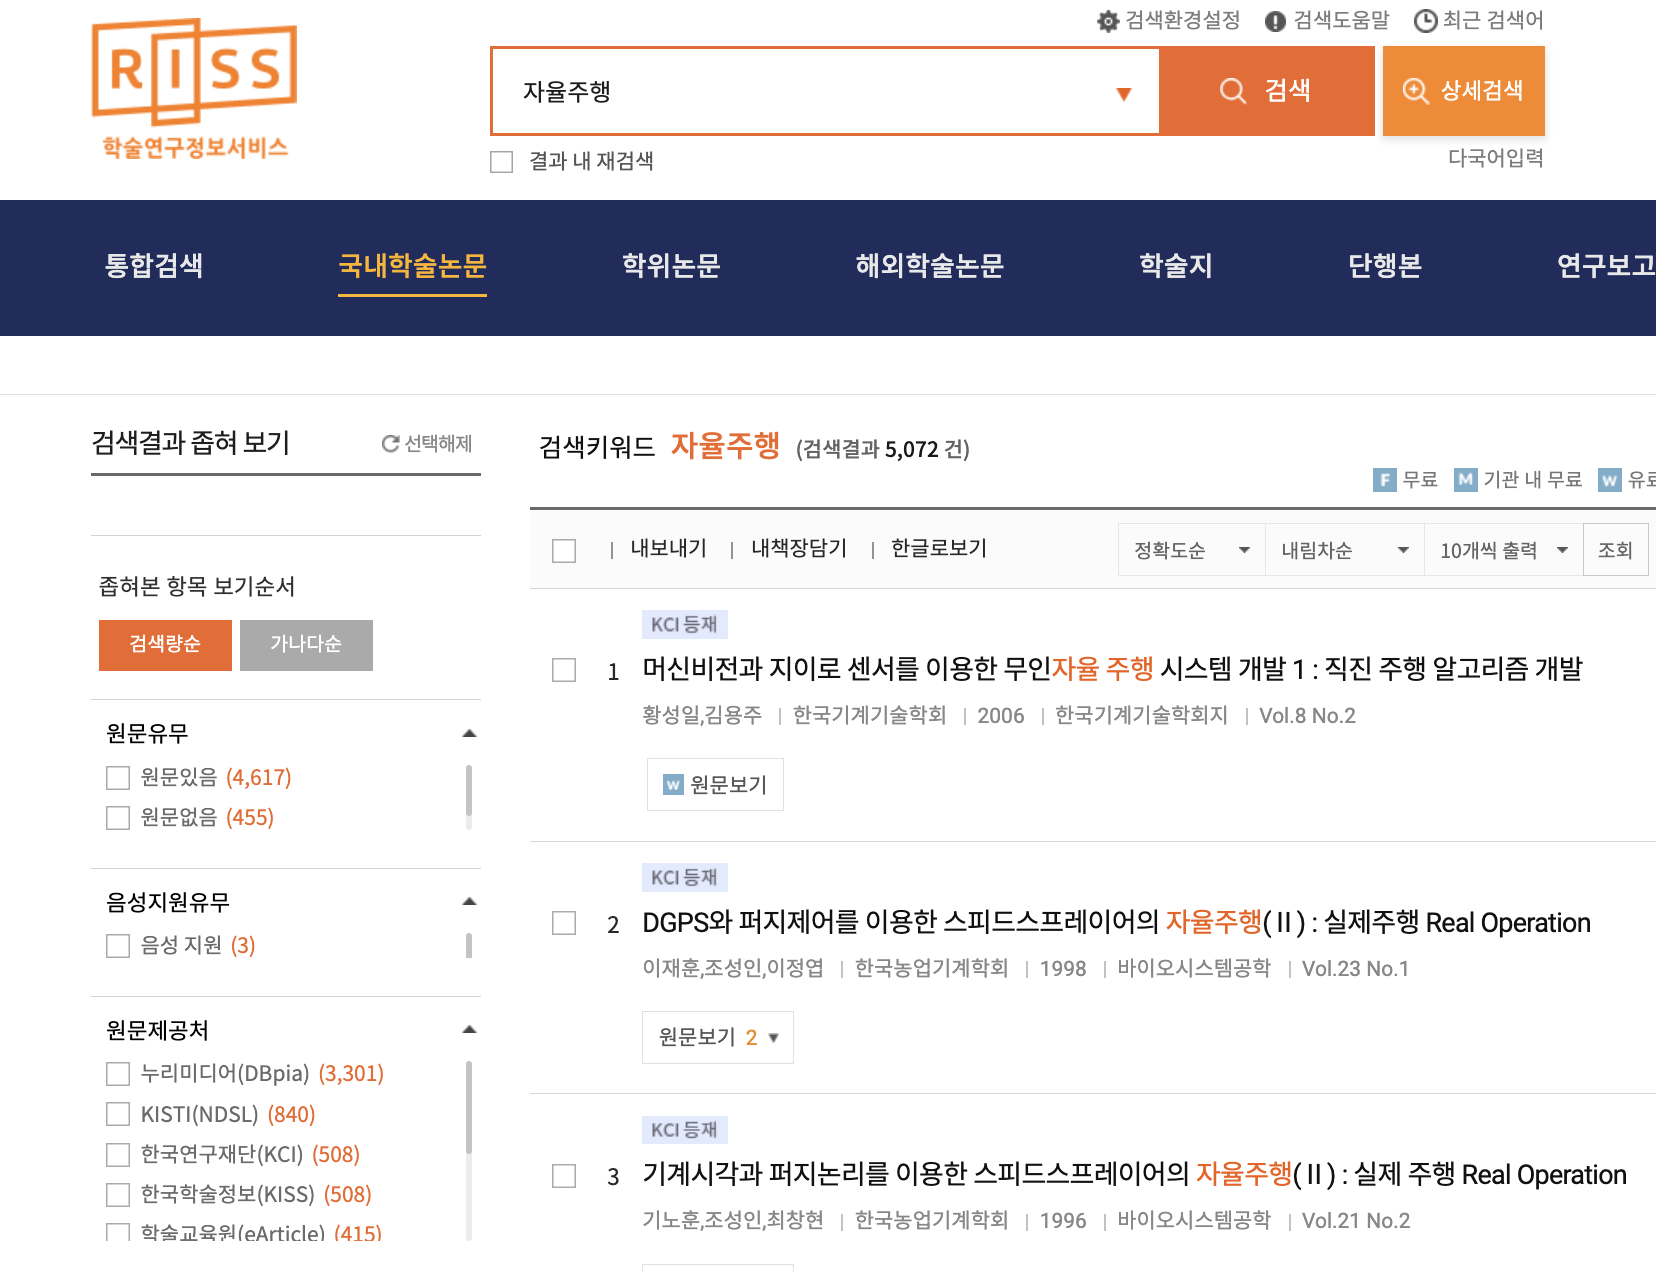

## 가져오고자 하는 것들
- 논문 제목
- 논문 발행 년도 (월도 추출 가능한지)

# 분석하기 1
## url 가져오기

- 왼쪽 카테고리에서 2022-2018년도 5개선택후 실행
- 오른쪽 콘텐츠 쪽 상위 카테고리에서 연도별, 내림차순으로 선택한 후 조회

In [4]:
#http://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery=자율주행Query=pyear%3A2022%E2%97%88pyear%3A2021%E2%97%88pyear%3A2020%E2%97%88pyear%3A2019%E2%97%88pyear%3A2018%E2%97%88&exQueryText=%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2022%5D%40%40pyear%3A2022%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2021%5D%40%40pyear%3A2021%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2020%5D%40%40pyear%3A2020%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2019%5D%40%40pyear%3A2019%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2018%5D%40%40pyear%3A2018%E2%97%88&order=%2FDESC&onHanja=false&strSort=DATE&p_year1=&p_year2=&iStartCount=100&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=search&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList=&facetListText=&fsearchDB=&icate=re_a_kor&colName=re_a_kor&pageScale=100&isTab=Y&regnm=&dorg_storage=&language=&language_code=&clickKeyword=&relationKeyword=&query=%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89
#이 URL을 위 아래로 쪼개야 한다. 
#이러면 페이지 구분없이, 입력된 page

#키워드 입력
키워드 = '자율주행'
#URL 앞 -- 키워드 변경 가능
url_front = f"http://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery={키워드}Query=pyear%3A2022%E2%97%88pyear%3A2021%E2%97%88pyear%3A2020%E2%97%88pyear%3A2019%E2%97%88pyear%3A2018%E2%97%88&exQueryText=%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2022%5D%40%40pyear%3A2022%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2021%5D%40%40pyear%3A2021%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2020%5D%40%40pyear%3A2020%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2019%5D%40%40pyear%3A2019%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2018%5D%40%40pyear%3A2018%E2%97%88&order=%2FDESC&onHanja=false&strSort=DATE&p_year1=&p_year2=&iStartCount="
#URL 뒤 -- 
url_back = "&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=search&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList=&facetListText=&fsearchDB=&icate=re_a_kor&colName=re_a_kor&pageScale=&isTab=Y&regnm=&dorg_storage=&language=&language_code=&clickKeyword=&relationKeyword=&query=%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89"

#get_URL 함수 정의
def get_URL(page):
    URL = url_front + page + url_back
    return URL

In [5]:
#논문 검색시 나온 검색결과가 5069건..인줄 알았는데
#아까 선택했던(연도 여러개)게 적용이 안되어서
#2022 (202), 2021 (1,009), 2020 (695), 2019 (737), 2018 (616)
#합해보니 3259! 구분페이지 326까지만 보면 되겠다.
#그러면 range(0,326)
page_URL = []
for i in range(0, 326):
    a = get_URL(str(i*10))
    page_URL.append(a)

In [6]:
len(page_URL)

326

In [7]:
page_URL[0]

'http://www.riss.kr/search/Search.do?isDetailSearch=N&searchGubun=true&viewYn=OP&queryText=&strQuery=자율주행Query=pyear%3A2022%E2%97%88pyear%3A2021%E2%97%88pyear%3A2020%E2%97%88pyear%3A2019%E2%97%88pyear%3A2018%E2%97%88&exQueryText=%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2022%5D%40%40pyear%3A2022%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2021%5D%40%40pyear%3A2021%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2020%5D%40%40pyear%3A2020%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2019%5D%40%40pyear%3A2019%E2%97%88%EB%B0%9C%ED%96%89%EC%97%B0%EB%8F%84+%5B2018%5D%40%40pyear%3A2018%E2%97%88&order=%2FDESC&onHanja=false&strSort=DATE&p_year1=&p_year2=&iStartCount=0&orderBy=&mat_type=&mat_subtype=&fulltext_kind=&t_gubun=&learning_type=&ccl_code=&inside_outside=&fric_yn=&image_yn=&gubun=&kdc=&ttsUseYn=&l_sub_code=&fsearchMethod=search&sflag=1&isFDetailSearch=N&pageNumber=1&resultKeyword=%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89&fsearchSort=&fsearchOrder=&limiterList=&limiterListText=&facetList

# 페이지 구조안에서 원하는 곳 찾기
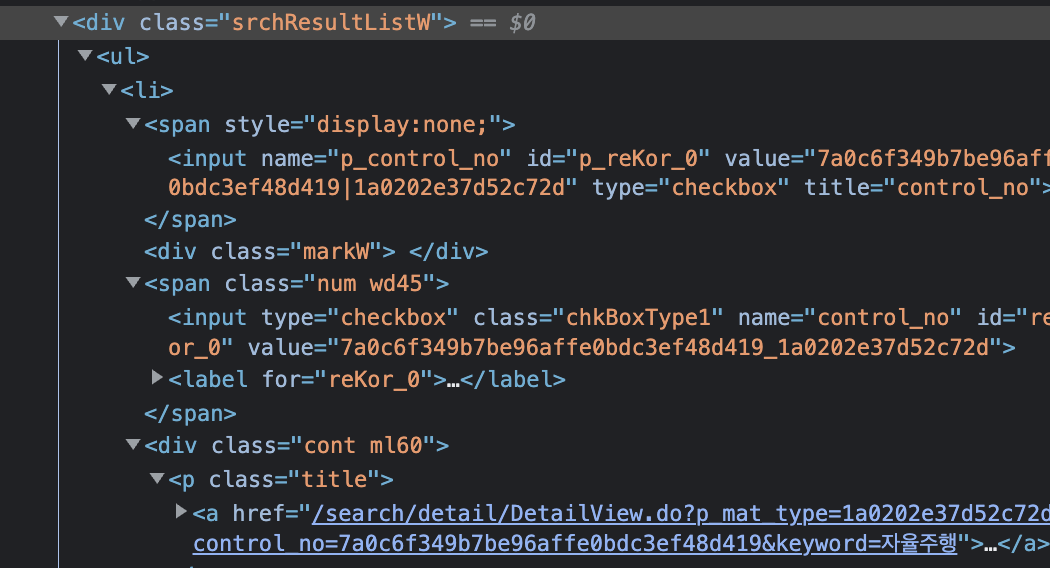

In [8]:
get_t_v= requests.get(page_URL[0])
Soup = BeautifulSoup(get_t_v.content, 'html.parser')
Soup


<!DOCTYPE html>

<html lang="ko">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="no-referrer-when-downgrade" name="referrer">
<meta content="width=device-width" name="viewport"/>
<meta content="telephone=no" name="format-detection"/><!-- 아이폰 전화번호 스타일 초기화 -->
<meta content="Copyright(c) KERIS. ALL RIGHTS  RESERVED" name="copyright"/>
<title>RISS 검색 - 국내학술지논문</title>
<link href="/commons/images/favicon.ico" rel="icon" type="image/x-icon"/>
<link href="/commons/images/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/commons/css/base.css?20220324" rel="stylesheet" type="text/css"/>
<link href="/commons/css/common.css?20220324" rel="stylesheet" type="text/css"/>
<link href="/search/css/search.css?20220324" rel="stylesheet" type="text/css"/>
<link href="/commons/css/jquery.mCustomScrollbar.css?20220324" rel="stylesheet" type="text/css"/>
<link href="/commons/css/relation/dtree.css?20220324" rel="StyleSheet" type="text/

In [13]:
data1= Soup.select('div.srchResultListW > ul > li ')
data1[9]
#data1[0부터 9까지 있음]
    
# 리스트는 p_reKor_숫자 로 구분된다! 0이 첫번째꺼 9가 마지막꺼
#그래서 전체페이지에서 이 숫자를 찾아서 그 li가 가진 링크를 가져오면
#전체페이지에서 한 주제에 해당하는 사이트에 들어갈 수 있다.

<li>
<span style="display:none;"><input id="p_reKor_9" name="p_control_no" title="control_no" type="checkbox" value="41fdaa384421a7bed18150b21a227875|1a0202e37d52c72d"/></span>
<div class="markW">
<span class="mark"><img alt="KCI등재" src="/search/images/kci.png"/></span>
</div>
<span class="num wd45">
<input class="chkBoxType1" id="reKor_9" name="control_no" type="checkbox" value="41fdaa384421a7bed18150b21a227875_1a0202e37d52c72d"/>
<label for="reKor_9"><span class="checkBox"></span>10</label>
</span>
<div class="cont ml60">
<p class="title"><a href="/search/detail/DetailView.do?p_mat_type=1a0202e37d52c72d&amp;control_no=41fdaa384421a7bed18150b21a227875&amp;keyword=자율주행">Performance Analysis of RSU Relaying in the Vehicular Network</a></p>
<p class="etc">
<span class="writer"><a href="/search/Search.do?isDetailSearch=Y&amp;searchGubun=true&amp;queryText=znCreator,Hye+Young+An%28%EC%95%88%ED%98%9C%EC%98%81%29&amp;colName=re_a_kor">Hye Young An(안혜영)</a>,<a href="/search/Search.do?isDetail

In [14]:
p = data1[0].find('p', {'class' :'title'})
#주소불러왔긔
#여기서 href에 해당하는 값 가져와서 들어가면 된당
#http://riss.kr/해당하는값 하면 들어갈수 있댬ㅎㅠ
p

<p class="title"><a href="/search/detail/DetailView.do?p_mat_type=1a0202e37d52c72d&amp;control_no=edbbd9efb58140ede9810257f7042666&amp;keyword=자율주행">인공지능(AI)활용 리스크에 대한 보험법의  대응과 과제</a></p>

In [27]:
pp = p.select('a')
pp[0]

<a href="/search/detail/DetailView.do?p_mat_type=1a0202e37d52c72d&amp;control_no=edbbd9efb58140ede9810257f7042666&amp;keyword=자율주행">인공지능(AI)활용 리스크에 대한 보험법의  대응과 과제</a>

In [28]:
n_url = pp[0].get('href')
n_url

'/search/detail/DetailView.do?p_mat_type=1a0202e37d52c72d&control_no=edbbd9efb58140ede9810257f7042666&keyword=자율주행'

In [29]:
r_url = "http://www.riss.kr" + n_url
print(r_url)

http://www.riss.kr/search/detail/DetailView.do?p_mat_type=1a0202e37d52c72d&control_no=edbbd9efb58140ede9810257f7042666&keyword=자율주행


# 이제 상세페이지 안으로! 진짜 원하는걸 찾자
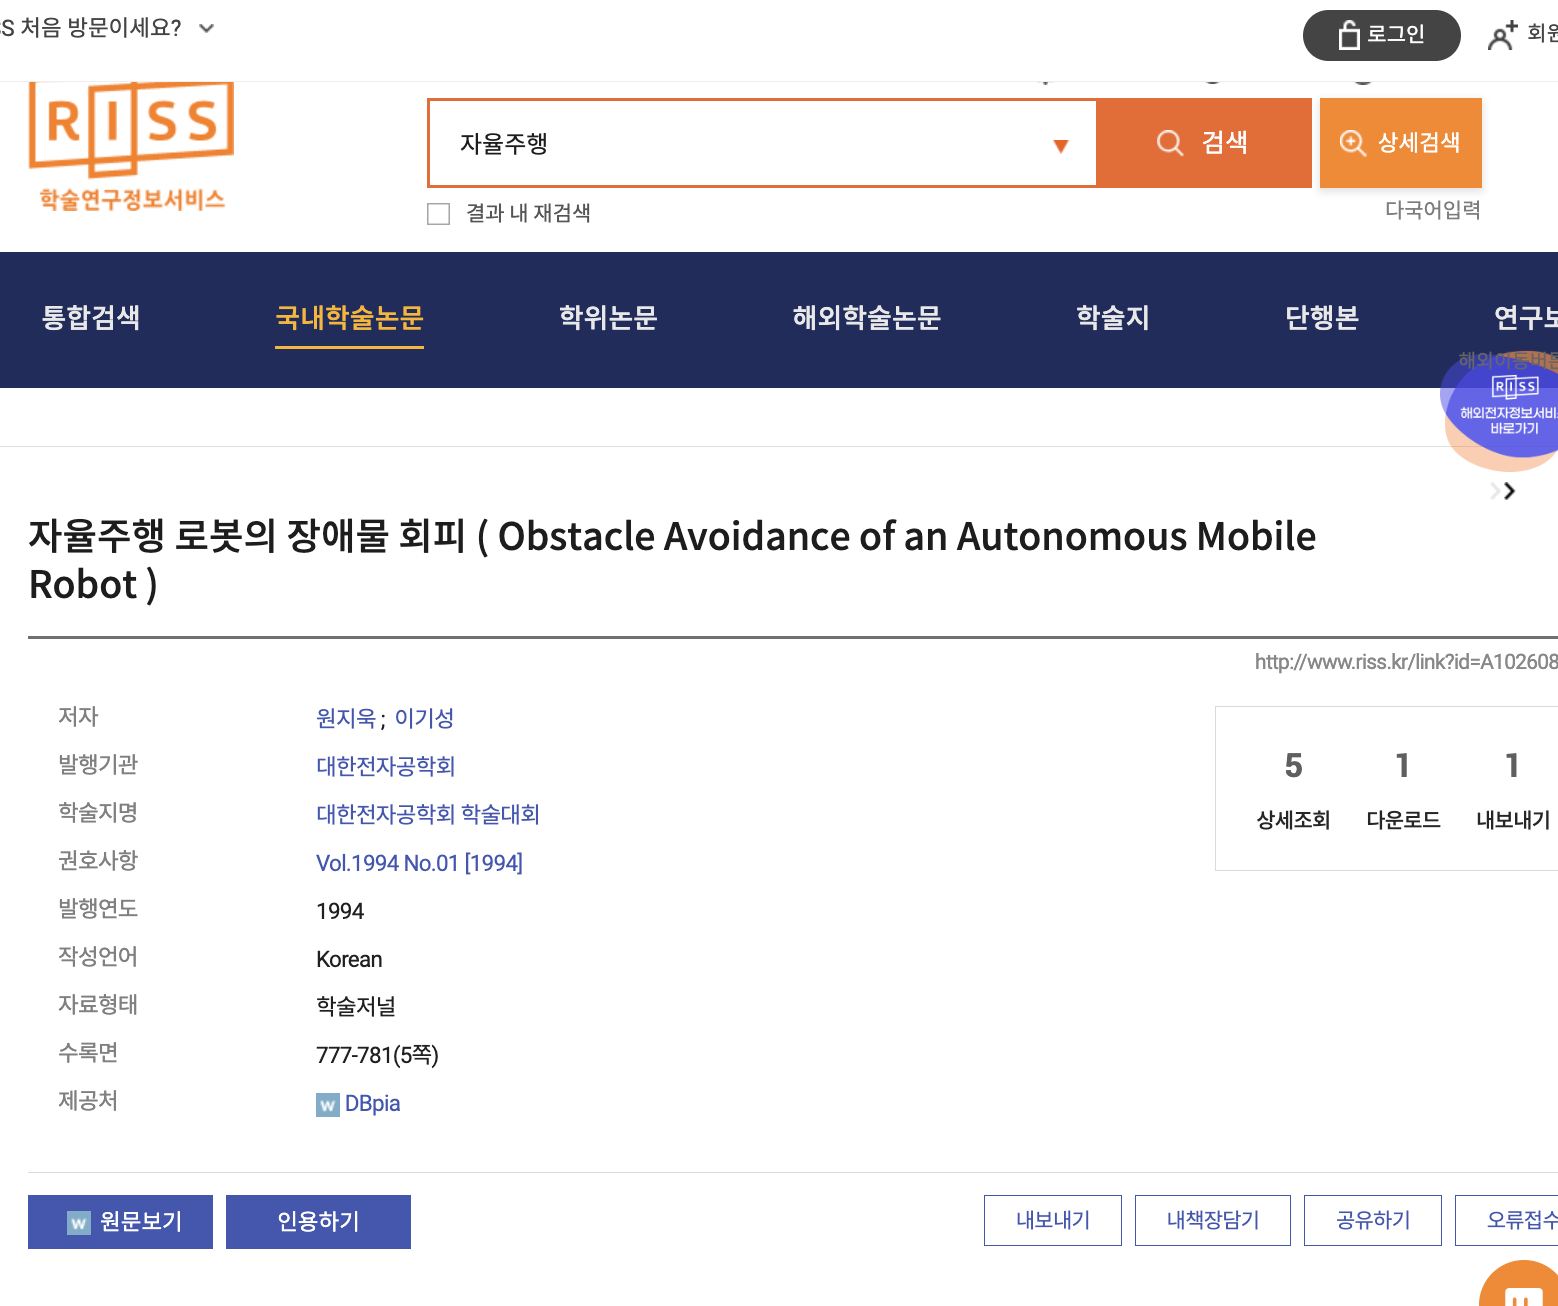

### 우리가 찾을건
- 제목
- 발행기관
- 발행연도

## 또 페이지 구조를 본다. 이젠 쉬워진다!!!
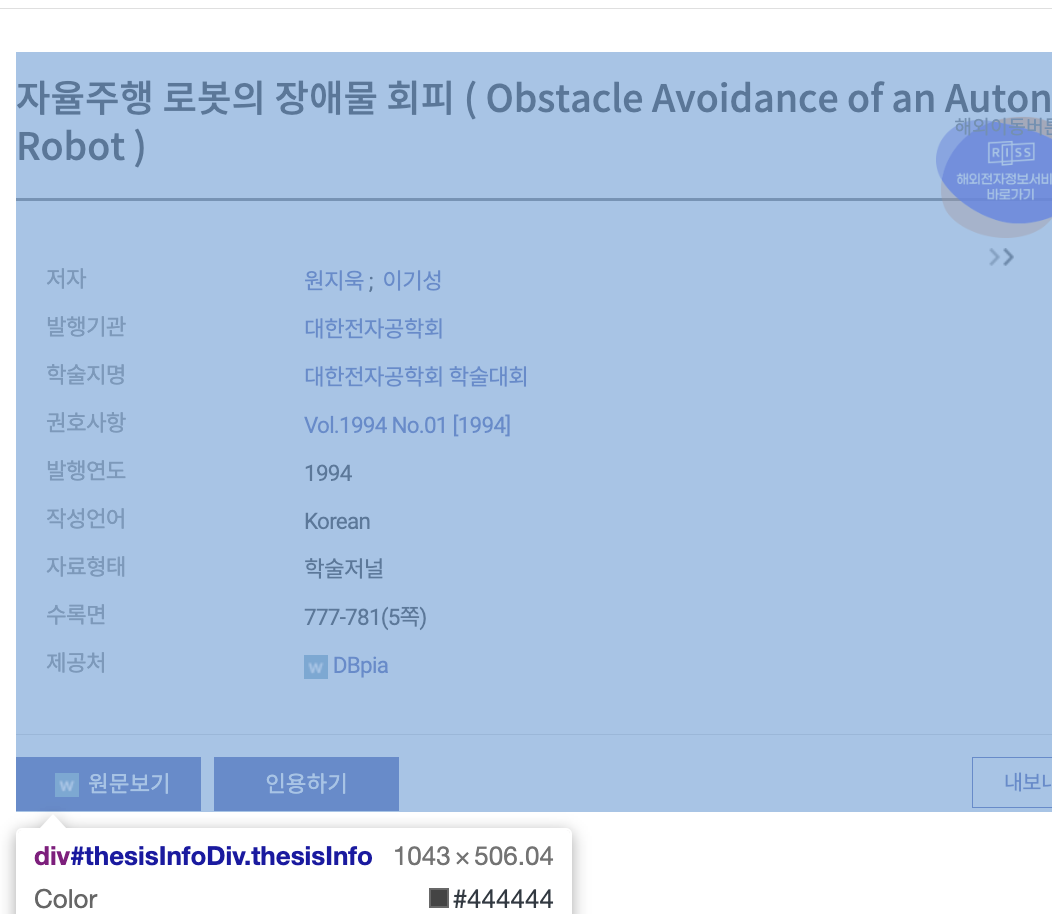
그리고 이제 촘촘히 들어가서 찾는다! ㄲ

In [30]:
real_t= requests.get(r_url)
realsoup = BeautifulSoup(real_t.content, 'html')
realsoup

<html>
<body>
<form action="http://sso.riss.kr:11301/cdc_read_relay.jsp" method="POST" name="f">
<input name="SAMLRequest" type="hidden" value="nVXbUtswEH3PV3jEI+OLHAqJJw4TSC+ZQkuTADO8dIS0TtQ6kquVE+DrKzsJOBQ6tA/2eFa75+zlrNw7vlvk3hIMSq1SQoOIeKC4FlLNUnI5/eB3yHG/1eohW+RFMijtXI3hVwloPRepMKkPUlIalWiGEhPFFoCJ5clkcH6WxEGUFEZbzXVO1iF/d2aIYKzLhniD7eepVlguwEzALCWHy/FZSubWFkkYrlarwEjE4KcJsQgqmPdKFFoqS7yhS1MqZuvaNgGIehuQUNqOaMgF/26ACffK2X3wAwvijYYpiUS3y9+9437cPuj6NItv/Yx2wD88hCPIWEQP2JHzRCxhpNAyZVMSR3HsR4c+7UxpN4m7CT28Id7FpgEnUq0b+6wBQbMBt2snTD5Npxf+GIQ0wG0NspQCzBcX4ZKjwXg0mcRREFHiXW0H6ABIv+V5vTot02+69cKNsTqvUEbiQueS33uDPNerU9cD65CtKYF4H7RZMPv6qGhAa4sUfla7JqXCArjMJAjS74VNgppRYDKRMzeN0sBGOwJ35rhqB9rMwjiKojDqhs5HoJzt1QU9AYAYqUyvbWvrKVNaSc5y+VDP+hzsXAtX1UwbaeeLV0hoSKOKxIc77nN6oPaqvF/FazI+FvJGqp165gvGfZwzuqF7BtbkGUMGxu0jeJfjUUr23iTJLcAaYmqYwmpE+GR/dvJv6YNaQq4LED5uE98U8gj4/0wvzaQBVglb8bxEuYRKYFgwDri9Vt6K6FYJMnl3JtEJfE+4xpW59aqLrH4VnnCQKNwjq8peYNwp8JXSd+24O5WhnLm76X/U0xBOE+Ql+CuWl9C/xM7DUZax0d3qa7vz/uKo

## 사람인척하기
내가 찾으려고 하는건 위에 것이 아니다 ㅠㅠ div같은게 아예 없다!! 막힌듯.. ㅠ
그래서!! 
사람인 척 해야한다.


https://chromedriver.storage.googleapis.com/index.html?path=102.0.5005.61/
    에서 크롬드라이버 깔기
    

In [48]:
real_t= requests.get(r_url)
realsoup = BeautifulSoup(real_t.text, 'lxml')
realsoup

<html>
<body>
<form action="http://sso.riss.kr:11301/cdc_read_relay.jsp" method="POST" name="f">
<input name="SAMLRequest" type="hidden" value="nVXbctowEH3nKzzi2RdBoODBdGhIGiaQZLgkk750FGsBpUZytDIk/frKBhKTJp00D/Z4Vrvn7OWs3Pn6uEqcNWgUSkaEegFxQMaKC7mIyGx66rbI126l0kG2StKwl5mlHMNDBmgcGykxLA4ikmkZKoYCQ8lWgKGJw0lvNAxrXhCmWhkVq4RsQ/7tzBBBG5sNcXr7z2MlMVuBnoBeixhm42FElsakoe9vNhtPC0Tvl/Yx9XKYE8lTJaQhTt+mKSQzRW27AES1DwgprQfUj3n8UwPj9pWwJ+8eU+IM+hGpxbxZ4+0jt37XmLsN1mi4bRbU3fZRs9mANqPQ4NYTMYOBRMOksTFBreYGTZe2prQd1r+E9OgHca52Dfgm5LaxrxrglRtwt3XC8Gw6vXLHwIWG2BQga8FBX9iIiATUGw8mk1rgBZQ41/sBWgDSrThOp0hLd8tuHX9nzM9zlAG/UomIn5xekqjNse2BschGZ0CcU6VXzLw/KurRwiK4Oy9cw0xiCrGYC+Ck2/HLBAUjx3AiFnYamYaddjgezHFT95Re+LUgCPyg7VsfjmJRLQp6AQA+kHO1tW2tx0wqKWKWiN/FrEdglorbqhZKC7NcvUNCfRrkJC48xm5Mj2Q1z/tdvDLjcyEfpDqoZ7lisYtLRnd0r8DKPGOYg7b7CM5sPIhI9UOS3ANsIaaaScxHhC/2Vyf/lz7INSQqBe7iPvFdIc+An2d6ayYlsFzYMk4yFGvIBYYpiwH318pHEe0qwVw8DgVagVc5zFmWGCe/yIpX6nALidw+Iq/sDcaDAt8p/dCOh1Ppi4W9mz6jnpJwyiBvwV+zJIPuU3qxGYzEQ+/Gv1ebFsf1

In [37]:
driver = webdriver.Chrome(executable_path='/Users/jeon-eunji/Documents/GitHub/TIL/크롤링/chromedriver')

In [66]:
driver.get(r_url)
driver.maximize_window()

<html lang="ko"><head><script async="" src="http://www.google-analytics.com/plugins/ua/linkid.js" type="text/javascript"></script><script src="https://m.addthis.com/live/red_lojson/300lo.json?si=62ae2d819ffe018f&amp;bkl=0&amp;bl=1&amp;pdt=682&amp;sid=62ae2d819ffe018f&amp;pub=keris&amp;rev=v8.28.8-wp&amp;ln=ko&amp;pc=men&amp;cb=0&amp;ab=-&amp;dp=www.riss.kr&amp;fp=search%2Fdetail%2FDetailView.do%3Fp_mat_type%3D1a0202e37d52c72d%26control_no%3Dedbbd9efb58140ede9810257f7042666%26keyword%3D%25EC%259E%2590%25EC%259C%25A8%25EC%25A3%25BC%25ED%2596%2589&amp;fr=&amp;of=0&amp;pd=0&amp;irt=0&amp;vcl=0&amp;md=0&amp;ct=1&amp;tct=0&amp;abt=0&amp;cdn=0&amp;pi=1&amp;rb=2&amp;gen=100&amp;chr=UTF-8&amp;colc=1655582083092&amp;jsl=1&amp;uvs=62ae2d8173ec92c5000&amp;skipb=1&amp;callback=addthis.cbs.jsonp__285599459142488850" type="text/javascript"></script><script src="https://v1.addthisedge.com/live/boost/keris/_ate.track.config_resp" type="text/javascript"></script><script async="" src="//www.google-analyt
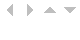

In [70]:
html_1 = driver.page_source
soup_1 = BeautifulSoup(html_1, 'html.parser')
soup_1

In [96]:
title = soup_1.find("h3", "title")
title_txt = title.get_text("", strip = True)
#get_text()메서드는 현재 태그를 포함하여 모든 하위 태그를 제거하고 유니코드 텍스트만 들어있는 문자열을 반환한다.
title_txt = title_txt.replace("\n", "").replace("\t", "")
title_txt

"인공지능(AI)활용 리스크에 대한 보험법의  대응과 과제                      = Insurance Law's Response to AI Utilization Risks and Future Tasks"

In [105]:
detail = soup_1.select('div.infoDetailL > ul > li')
detail

[<li>
 <span class="strong">저자</span>
 <div>
 <p>
 <a href="/search/Search.do?queryText=znCreator,%EC%B5%9C%EB%B3%91%EA%B7%9C&amp;searchGubun=true&amp;colName=re_a_kor&amp;isDetailSearch=Y">최병규</a>
 </p>
 </div>
 </li>,
 <li>
 <span class="strong">발행기관</span>
 <div><p><a href="/search/Search.do?queryText=znPublisher,%ED%95%9C%EA%B5%AD%EC%83%81%EC%82%AC%EB%B2%95%ED%95%99%ED%9A%8C&amp;searchGubun=true&amp;colName=re_s&amp;isDetailSearch=Y">한국상사법학회</a></p></div>
 </li>,
 <li>
 <span class="strong">학술지명</span>
 <div><p><a class="text mgb7" href="/link?id=S25211">商事法硏究</a></p></div>
 </li>,
 <li>
 <span class="strong">권호사항</span>
 <div>
 <p>
 <a href="/search/detail/DetailView.do?p_mat_type=3a11008f85f7c51d&amp;control_no=f47c5cac67215dc1&amp;v_control_no=a2614ca4fde86d11ffe0bdc3ef48d419">
 					   			Vol.41
 					   			No.1
 					   			[2022]
 					   			</a>
 </p>
 </div>
 </li>,
 <li>
 <span class="strong">발행연도</span>
 <div><p>2022</p></div>
 </li>,
 <li>
 <span class="strong">작성언어</span

In [115]:
#저자 detail[0]
detail[0].find_all("a")[0].get_text("", strip = True)

'최병규'

In [117]:
#발행기관 detail[1]
detail[1].find_all("a")[0].get_text("", strip=True)

'한국상사법학회'

In [133]:
#발행연도
detail[4].find_all("p")[0].get_text("", strip = True)

'2022'

In [138]:
#주제어
subject = []
for i in range(len(detail[6].find_all("a"))):
    val = detail[6].find_all("a")[i].get_text("", strip=True)
    subject.append(val)
subject

['artificial intelligence',
 'artificial intelligence ethics',
 'civil liability',
 'self-driving car',
 'solution by insurance',
 'liability insurance',
 'product liability insurance',
 'defense of development risk',
 '인공지능',
 '인공지능 윤리',
 '민사책임',
 '자율주행자동차',
 '보험에 의한 해결',
 '책임보험',
 '제조물책임보험',
 '개발위험의 항변']

In [ ]:

    html = driver.page_source
    soup = bs(html, "html.parser")
    title = soup.find("h3", "title")
    title_txt = title.get_text("", strip = True)
    title_kor = re.sub("\n\b", "", str(title_txt).strip())

    txt_box = []
    for text in soup.find_all("div", "text"):
        txt = text.get_text("", strip = True)
        txt_box.append(txt)
        
    txt_kor = txt_box[1]
    txt_eng = txt_box[3]
    
    detail_box = []
    detail_info = soup.select(
        "#soptionview > div > div.thesisInfo > div.infoDetail.on > div.infoDetail > ul > li > div > p"
    )
    
    for detail in detail_info:
        detail_content = detail.get_text("", strip=True)
        detail_wrap =[]
        detail_wrap.append(detail_content)
        
        detail_box.append(detail_wrap)
        
    author = ",".join(detail_box[0])
    book = (
    "".join(detail_box[2] + detail_box[3].replace("\n", "").replace("\t", "").replace(" ", ""))
    + "p." + "".join(detail_box[-2])
    )
    keyword = ",".join(detail_box[6])
    
    reference_data = pd.DataFrame(
        {
            "저자" : [author],
            "국문제목" : [title_kor],
            "영문제목" : [title_eng],
            "수록지" : [book],
            "핵심어" : [keyword],
            "국문 요약" : [txt_kor],
            "영문 요약" : [txt_eng],
            "링크" : [URL]                   
        }
    )
    
    driver.close()
    return reference_data
    

In [208]:
#앞에서 select써서 그 다음에 또 select를 쓰고 싶으면 select.one을 쓴다.
#BeautifulSoup은 select가 한번밖에 지원이 안된다고...풍문으로 들음..

In [96]:
('meta[itemprop="name"][content]')('content')
data= Soup.select('div.srchResultListW > ul > li > span > input')
data

AttributeError: ResultSet object has no attribute 'select'. You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

In [25]:
def get_LINK(pageGubun_count):
    for i in range(pageGubun_count):
        current_page = i*10
        URL = get_URL(str(current_page))
        source_code_from_URL = urllib.request.urlopen(URL)
        soup = bs(source_code_from_URL, 'lxml', from_encoding='utf-8')

In [28]:
get_LINK(int(4))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 86-89: ordinal not in range(128)

In [23]:
UURRLL = get_URL(str(0))
source = urllib.request.urlopen(UURRLL)
source

UnicodeEncodeError: 'ascii' codec can't encode characters in position 86-89: ordinal not in range(128)

In [4]:
#페이지 불러온다음에 제목 클릭해서 세부정보로 들어가야한다.
#논문 내용, 제목, 저자, 발행일 확인을 위함
def get_LINK(csv_name, page_num):
    for i in range(page_num):
        current_page = i*10
        URL = get_URL(str(current_page))
        source_code_from_URL = urllib.request.urlopen(URL)
        soup = bs(source_code_from_URL, 'lxml', from_encoding='utf-8')
        
        for j in range(10):
            paper_link = soup.select('li > div.cont > p.title > a')[j]['href']
            paper_url = "http://riss.kr" + paper_link
            
            reference_data = get_reference(paper_url)
            
            save_csv(csv_name, reference_data)

In [5]:
def get_reference(URL):
    driver_path = os.path.join(ROOT_PATH, "chromedriver")
    driver = webdriver.Chrome(driver_path, options = webdriver.ChromeOptions().add_argument("headless"))
    drive.get(URL)
    
    html = driver.page_source
    soup = bs(html, "html.parser")
    title = soup.find("h3", "title")
    title_txt = title.get_text("", strip = True)
    title_kor = re.sub("\n\b", "", str(title_txt[0]).strip())

    txt_box = []
    for text in soup.find_all("div", "text"):
        txt = text.get_text("", strip = True)
        txt_box.append(txt)
        
    txt_kor = txt_box[1]
    txt_eng = txt_box[3]
    
    detail_box = []
    detail_info = soup.select(
        "#soptionview > div > div.thesisInfo > div.infoDetail.on > div.infoDetail > ul > li > div > p"
    )
    
    for detail in detail_info:
        detail_content = detail.get_text("", strip=True)
        detail_wrap =[]
        detail_wrap.append(detail_content)
        
        detail_box.append(detail_wrap)
        
    author = ",".join(detail_box[0])
    book = (
    "".join(detail_box[2] + detail_box[3].replace("\n", "").replace("\t", "").replace(" ", ""))
    + "p." + "".join(detail_box[-2])
    )
    keyword = ",".join(detail_box[6])
    
    reference_data = pd.DataFrame(
        {
            "저자" : [author],
            "국문제목" : [title_kor],
            "영문제목" : [title_eng],
            "수록지" : [book],
            "핵심어" : [keyword],
            "국문 요약" : [txt_kor],
            "영문 요약" : [txt_eng],
            "링크" : [URL]                   
        }
    )
    
    driver.close()
    return reference_data
    

In [6]:
def save_csv(csv_path, data):
    csv = csv_path.replace("/", "\\")
    
    if os.path.isfile(csv_path):
        data.to_csv(csv, mode ='a', header = False, index = False )
        
    else:
        data.to_csv(csv, mode = "w", header = True, index = False)

In [13]:
def make_folder(folder_name):
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

if __name__ == "__main__":
    now = datetime.datetime.now().strftime("%Y-%m-%d")
    user_name = getpass.getuser()
    folder_root = "/Users/jeon-eunji/Documents/GitHub/Self-Analysis"
    path = folder_root + now
    make_folder(path)
    
    filename = input("저장할 csv이름 입력하세요")
    csv_path = path + "/" + filename + ".csv"
    page_num = input("크롤링할 페이지 수를 입력해주세요")
    get_LINK(csv_path, int(page_num))

In [19]:
path = '/Users/jeon-eunji/Documents/GitHub/Self-Analysis'
filename = input("저장할 csv이름 입력하세요")
csv_path = path + "/" + filename + ".csv"
page_num = input("크롤링할 페이지 수를 입력해주세요")


get_LINK(csv_path, int(page_num))

저장할 csv이름 입력하세요크롤
크롤링할 페이지 수를 입력해주세요10


UnicodeEncodeError: 'ascii' codec can't encode characters in position 86-89: ordinal not in range(128)